In [1]:
import math
import os
from pprint import pprint

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch

from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

from application.utilities.config.storage import ExperimentType
from utilities.storage import (
    get_dot_product_bm25_selected_files, get_dot_product_bm25_selected_model_generated_files,
    get_results_parameters_per_layer_folder_path, get_results_accuracy_per_layer_folder_path,
    get_results_layer_comparison_full_gradient_folder_path
)
from utilities.model import get_model, get_num_parameters_per_layer

[2025-05-05 20:50:32,268] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


INFO:root:gcc -pthread -B /home/lukashinterleitner/anaconda3/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/lukashinterleitner/anaconda3/include -fPIC -O2 -isystem /home/lukashinterleitner/anaconda3/include -fPIC -c /tmp/tmp2e2_z2vj/test.c -o /tmp/tmp2e2_z2vj/test.o
INFO:root:gcc -pthread -B /home/lukashinterleitner/anaconda3/compiler_compat /tmp/tmp2e2_z2vj/test.o -laio -o /tmp/tmp2e2_z2vj/a.out
/home/lukashinterleitner/anaconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
INFO:root:gcc -pthread -B /home/lukashinterleitner/anaconda3/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/lukashinterleitner/anaconda3/include -fPIC -O2 -isystem /home/lukashinterleitner/anaconda3/include -fPIC -c /tmp/tmp99vl21tf/test.c -o /tmp/tmp99vl21tf/test.o
INFO:root:gcc -pthread -B /home/lukashinterleitner/anaconda3/compiler_compat /tmp/tmp99vl21tf/test.o -L/usr -L/usr/lib64 -lcufile -o /tmp/tmp99vl21t

In [2]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    # calculates the cosine similarity based on dot products
    return a_dot_b / (math.sqrt(a_dot_a) * math.sqrt(b_dot_b))

In [3]:
def calculate_score(gradient_similarities: dict):
    correct_counter = 0
    bm25_correct_counter = 0

    size = len(gradient_similarities.keys())

    for paraphrased_id, similarities in gradient_similarities.items():
        most_similar_original_id = max(similarities, key=similarities.get)
        correct_counter += int(paraphrased_id == most_similar_original_id)

        bm25_most_similar_original_id = list(similarities.keys())[0]
        bm25_correct_counter += int(paraphrased_id == bm25_most_similar_original_id)

    return correct_counter / size, bm25_correct_counter / size

In [4]:
def get_wrong_decisions(gradient_similarities: dict):
    wrong_decisions = []

    for original_id, similarities in gradient_similarities.items():
        most_similar_paraphrased_id = max(similarities, key=similarities.get)
        if original_id != most_similar_paraphrased_id:
            wrong_decisions.append(original_id)

    return wrong_decisions

In [5]:
def get_mean_similarity_of_most_similar_samples(gradient_similarities: dict, mean_function = np.mean):
    highest_similarities = []

    for original_id, similarities in gradient_similarities.items():
        highest_similarities.append(max(similarities.values()))

    return mean_function(highest_similarities)

In [6]:
def get_cosine_similarities(dot_product_storage_function, model_to_evaluate, sample_size) -> \
    tuple[
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, float]]
    ]:
    dot_products, paraphrased_dot_products, original_dot_products = dot_product_storage_function(model_to_evaluate, sample_size)

    # restructure such that layer is at outermost level in the dictionary for easier access afterward
    cosine_similarities_new_structure = dict()
    cosine_similarities_old_structure = dict()

    cosine_similarities_old_structure_combined = dict() # all gradients combined

    for paraphrased_id, values in dot_products.items():
        cosine_similarities_old_structure[paraphrased_id] = dict()
        cosine_similarities_old_structure_combined[paraphrased_id] = dict()

        for original_id, layers in values.items():
            cosine_similarities_old_structure[paraphrased_id][original_id] = dict()
            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = 0

            for layer, value in layers.items():
                if layer not in cosine_similarities_new_structure:
                    cosine_similarities_new_structure[layer] = dict()

                if paraphrased_id not in cosine_similarities_new_structure[layer]:
                    cosine_similarities_new_structure[layer][paraphrased_id] = dict()

                similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

                cosine_similarities_old_structure[paraphrased_id][original_id][layer] = similarity
                cosine_similarities_new_structure[layer][paraphrased_id][original_id] = similarity

                cosine_similarities_old_structure_combined[paraphrased_id][original_id] += value

            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = calculate_cosine_similarity(
                cosine_similarities_old_structure_combined[paraphrased_id][original_id],
                sum(paraphrased_dot_products[paraphrased_id].values()),
                sum(original_dot_products[original_id].values())
            )

    # check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            for original_id, similarity in original_ids.items():
                assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

    return cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined

In [7]:
def calculate_accuracy_per_layer(cosine_similarities_new_structure: dict):
    correct_counter_per_layer = defaultdict(int)

    # amount of paraphrased_samples
    size = len(next(iter(cosine_similarities_new_structure.values())).keys())

    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            most_similar_original_id = max(original_ids, key=original_ids.get)
            correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

        # divide by size to get percentage
        correct_counter_per_layer[layer] /= size

    return correct_counter_per_layer

In [8]:
def calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(
        similarities_per_layer_new_structure: dict[str, dict[str, dict[str, float]]],
        similarities_full_gradient_old_structure: dict[str, dict[str, float]],
) -> dict[str, float]:
    # compare each layer with the full gradient

    # flatten full gradient similarities for comparisons
    full_flattened = [item for values in similarities_full_gradient_old_structure.values() for item in values.values()]

    layer_similarity_compared_to_full_gradients = dict()

    for layer, similarities in similarities_per_layer_new_structure.items():
        layer_cosine_similarities_flattened = []

        for paraphrased_id, original_similarities in similarities.items():
            layer_cosine_similarities_flattened.extend(original_similarities.values())

        layer_similarity_compared_to_full_gradients[layer] = cosine_similarity(X=[layer_cosine_similarities_flattened], Y=[full_flattened])[0][0]

    return layer_similarity_compared_to_full_gradients

In [9]:
def horizontal_bar_plot(y, x, title, storage_folder_path, scale=None):
    plt.figure(figsize=(8, 25))
    sns.barplot(y = y, x = x, orient="h")
    plt.title(title)

    if scale is not None:
        plt.xscale(scale)

    plt.margins(y=0.01)

    plt.savefig(f"{storage_folder_path}/horizontal_bar_plot.png", bbox_inches="tight")
    plt.plot()

In [10]:
model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
#model_to_evaluate = "allenai/OLMo-7B-SFT-hf"
sample_size = 100

#model_to_evaluate = "openai-community/gpt2"
#sample_size = 3

In [11]:
model = get_model(model_to_evaluate, device=torch.device('cpu')) # load model on cpu since no more computations are needed

Device: cpu
Model parameters: 1176764416
OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb)

In [12]:
num_parameters_per_layer = get_num_parameters_per_layer(model)

pprint(num_parameters_per_layer, indent=4, sort_dicts=False)

{   'model.embed_tokens.weight': 103022592,
    'model.layers.0.self_attn.q_proj.weight': 4194304,
    'model.layers.0.self_attn.k_proj.weight': 4194304,
    'model.layers.0.self_attn.v_proj.weight': 4194304,
    'model.layers.0.self_attn.o_proj.weight': 4194304,
    'model.layers.0.mlp.gate_proj.weight': 16777216,
    'model.layers.0.mlp.up_proj.weight': 16777216,
    'model.layers.0.mlp.down_proj.weight': 16777216,
    'model.layers.1.self_attn.q_proj.weight': 4194304,
    'model.layers.1.self_attn.k_proj.weight': 4194304,
    'model.layers.1.self_attn.v_proj.weight': 4194304,
    'model.layers.1.self_attn.o_proj.weight': 4194304,
    'model.layers.1.mlp.gate_proj.weight': 16777216,
    'model.layers.1.mlp.up_proj.weight': 16777216,
    'model.layers.1.mlp.down_proj.weight': 16777216,
    'model.layers.2.self_attn.q_proj.weight': 4194304,
    'model.layers.2.self_attn.k_proj.weight': 4194304,
    'model.layers.2.self_attn.v_proj.weight': 4194304,
    'model.layers.2.self_attn.o_proj.

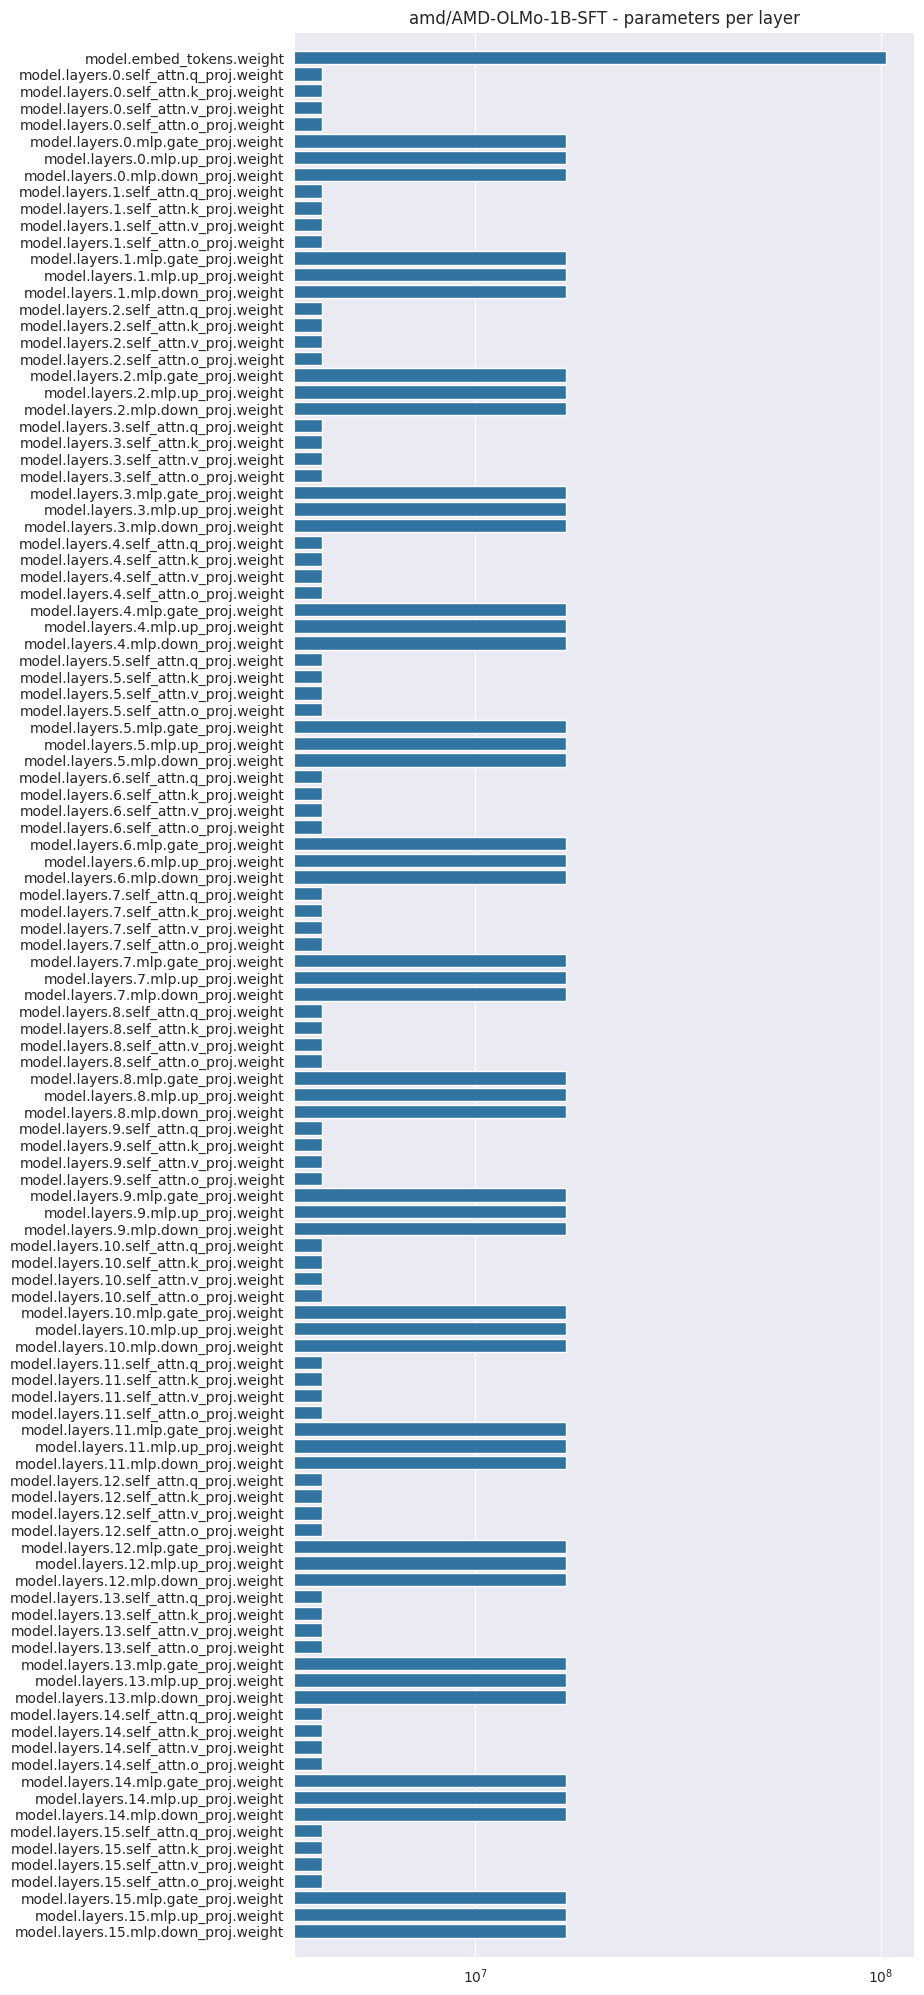

In [13]:
horizontal_bar_plot(
    y=list(num_parameters_per_layer.keys()),
    x=list(num_parameters_per_layer.values()),
    title=f"{model_to_evaluate} - parameters per layer",
    storage_folder_path=f"{get_results_parameters_per_layer_folder_path(model_to_evaluate)}",
    scale='log',
)

In [14]:
cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined = get_cosine_similarities(get_dot_product_bm25_selected_files, model_to_evaluate, sample_size)

# 1. BM25 Selected

In [15]:
model_score, bm25_score = calculate_score(cosine_similarities_old_structure_combined)
wrong_decisions = get_wrong_decisions(cosine_similarities_old_structure_combined)
mean_similarity = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined)
mean_similarity_score_median = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined, np.median)

print(f"Model score: {model_score}")
print(f"BM25 score: {bm25_score}")
print(f"Mean similarity (average): {mean_similarity}")
print(f"Mean similarity (median): {mean_similarity_score_median}")

Model score: 1.0
BM25 score: 0.99
Mean similarity (average): 0.5226305914835123
Mean similarity (median): 0.5039189776453838


## 1.1 Layer Analysis

In [16]:
accuracy_per_layer = calculate_accuracy_per_layer(cosine_similarities_new_structure)

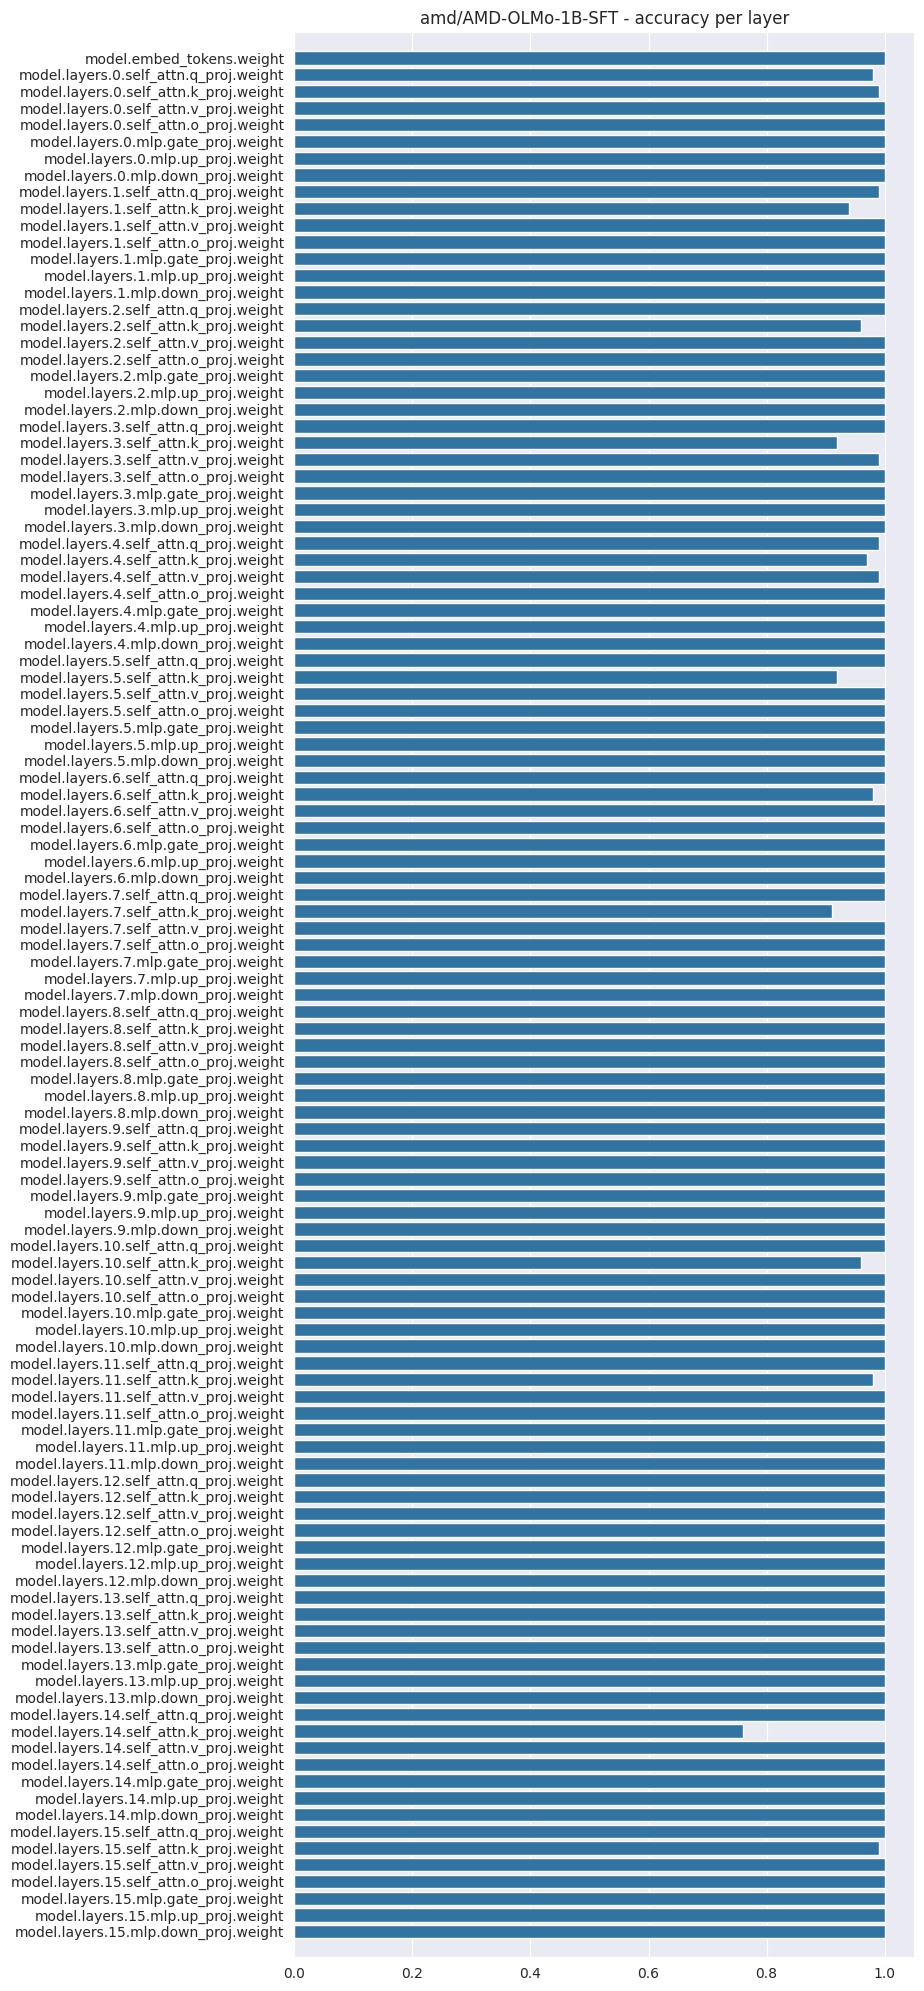

In [17]:
horizontal_bar_plot(
    y=list(accuracy_per_layer.keys()),
    x=list(accuracy_per_layer.values()),
    title=f"{model_to_evaluate} - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
)

## 1.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [18]:
layer_similarity_compared_to_full_gradients = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure, cosine_similarities_old_structure_combined)

In [19]:
max(layer_similarity_compared_to_full_gradients, key=layer_similarity_compared_to_full_gradients.get)

'model.layers.7.mlp.up_proj.weight'

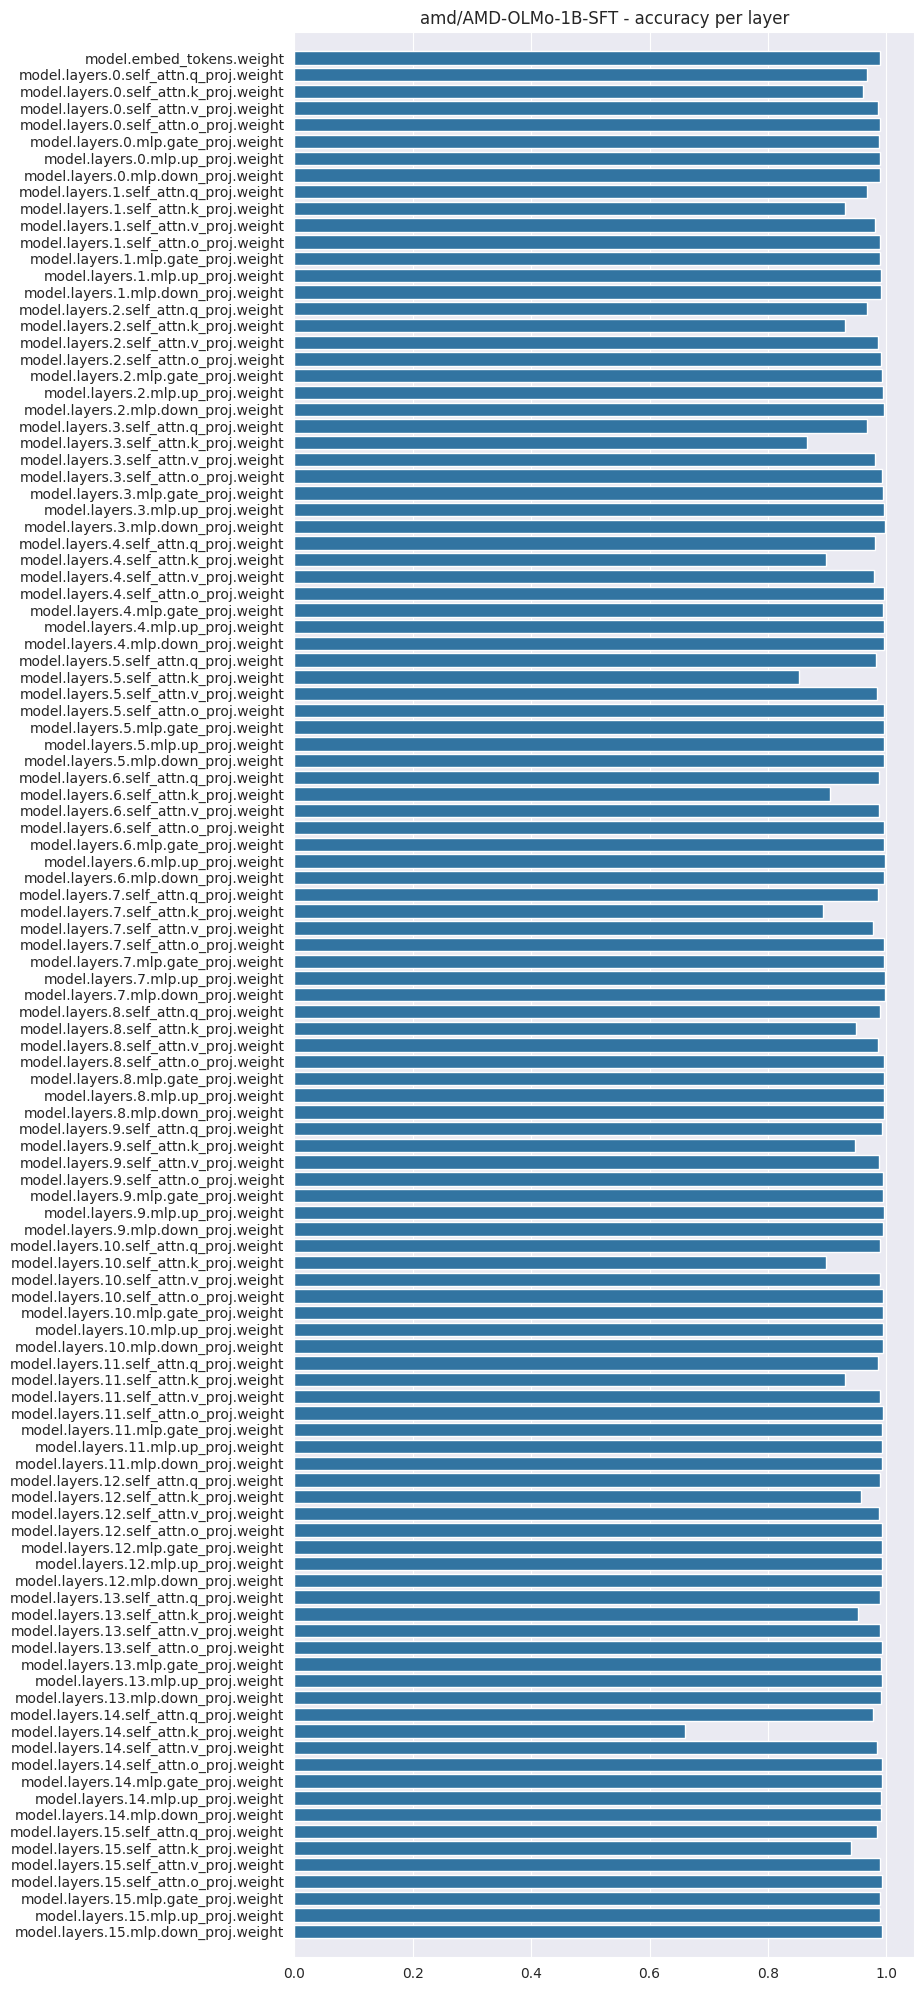

In [20]:
horizontal_bar_plot(
    y=list(layer_similarity_compared_to_full_gradients.keys()),
    x=list(layer_similarity_compared_to_full_gradients.values()),
    title=f"{model_to_evaluate} - accuracy per layer",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
)

# 2. BM25 Selected Model Generated

In [21]:
cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_model_generated, cosine_similarities_old_structure_combined_model_generated = get_cosine_similarities(get_dot_product_bm25_selected_model_generated_files, model_to_evaluate, sample_size)

In [22]:
model_score_model_generated, bm25_score_model_generated = calculate_score(cosine_similarities_old_structure_combined_model_generated)
wrong_decisions_model_generated = get_wrong_decisions(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_score_median_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated, np.median)

print(f"Model score: {model_score_model_generated}")
print(f"BM25 score: {bm25_score_model_generated}")
print(f"Mean similarity (average): {mean_similarity_model_generated}")
print(f"Mean similarity (median): {mean_similarity_score_median_model_generated}")

Model score: 0.21
BM25 score: 0.99
Mean similarity (average): 0.018239067627608973
Mean similarity (median): 0.011051601807393029


## 2.1 Layer Analysis

In [23]:
accuracy_per_layer_model_generated = calculate_accuracy_per_layer(cosine_similarities_new_structure_model_generated)

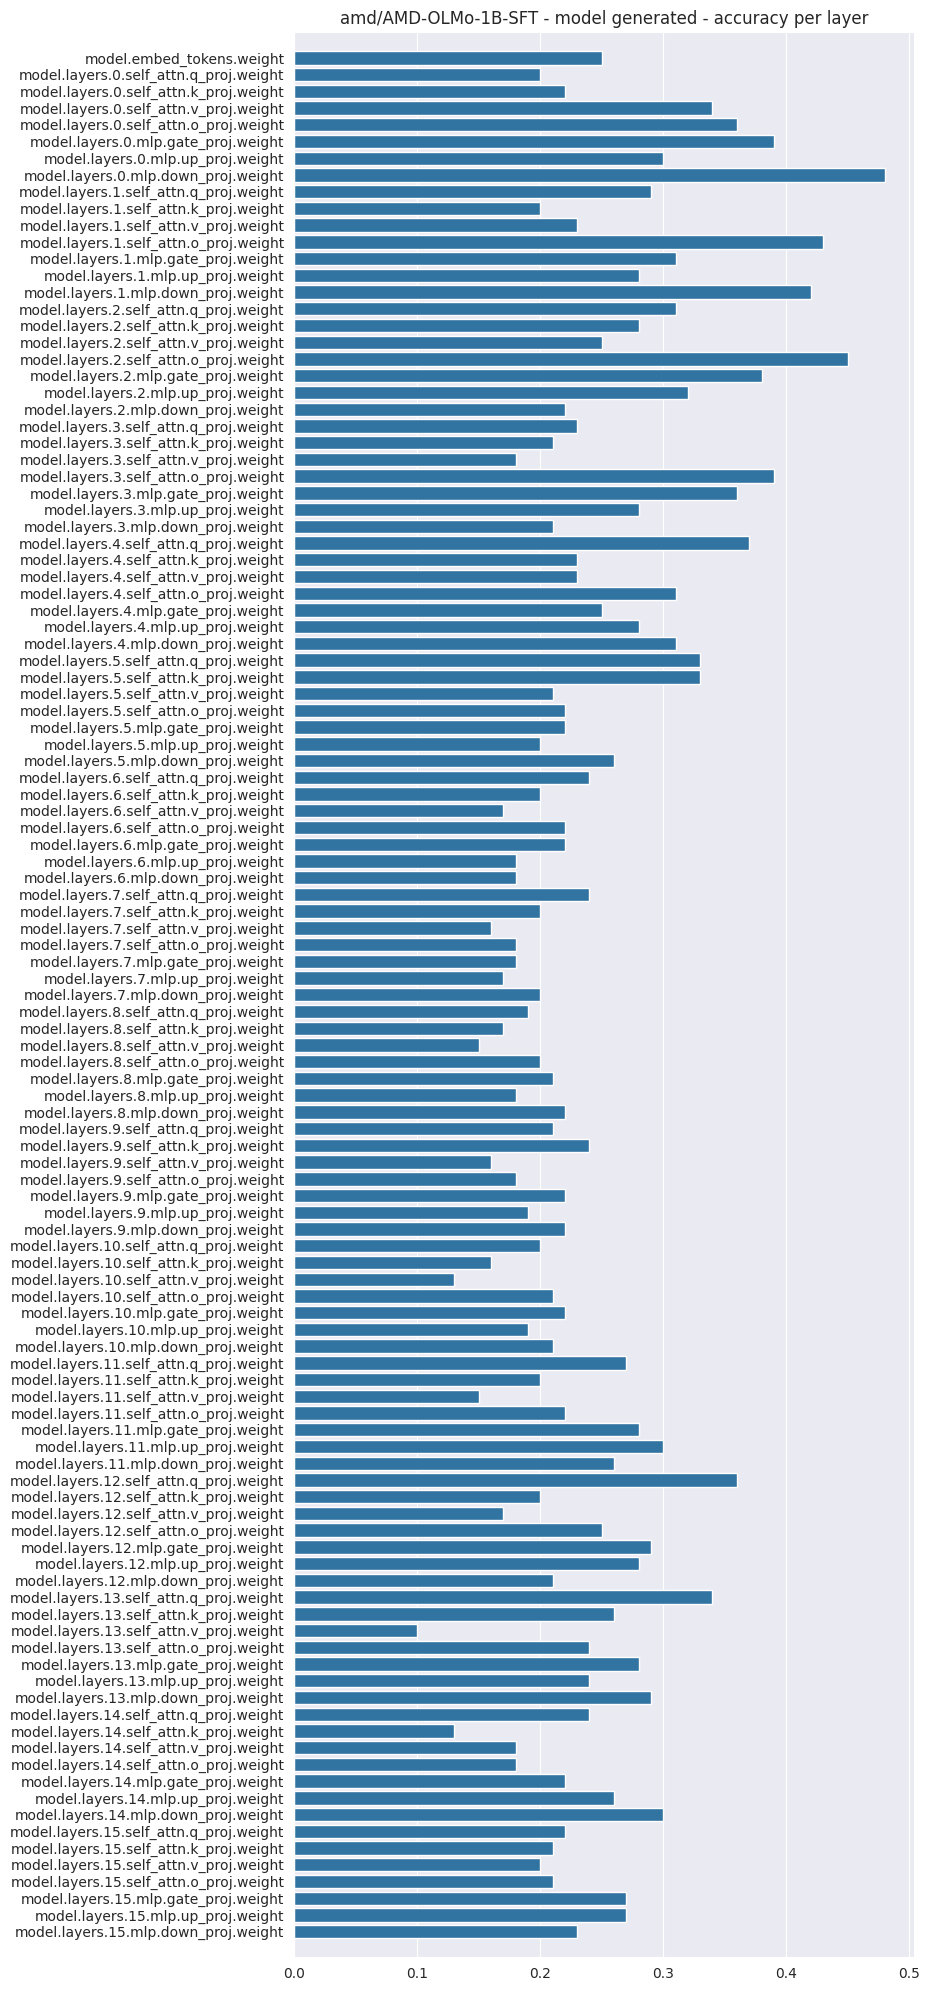

In [24]:
horizontal_bar_plot(
    y=list(accuracy_per_layer_model_generated.keys()),
    x=list(accuracy_per_layer_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
)

## 2.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [25]:
layer_similarity_compared_to_full_gradients_model_generated = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_combined_model_generated)

In [26]:
max(layer_similarity_compared_to_full_gradients_model_generated, key=layer_similarity_compared_to_full_gradients_model_generated.get)

'model.layers.3.mlp.down_proj.weight'

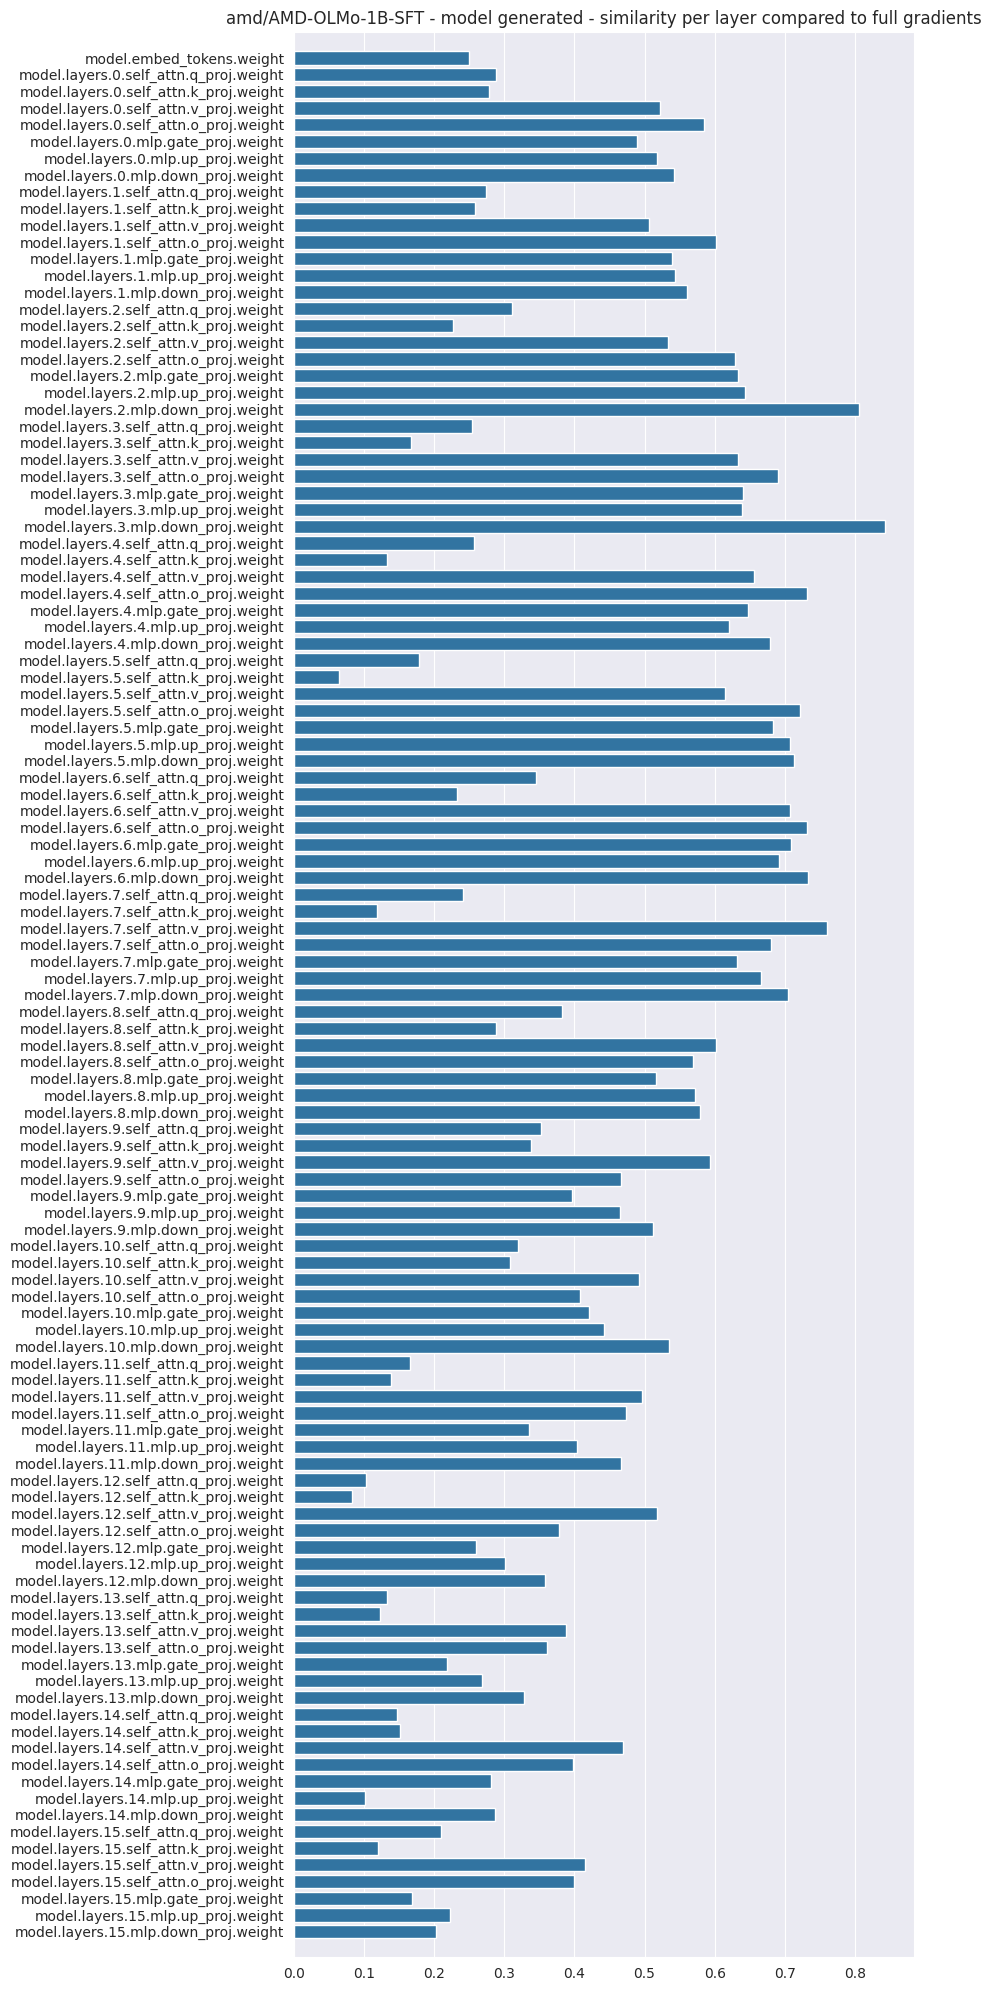

In [27]:
horizontal_bar_plot(
    y=list(layer_similarity_compared_to_full_gradients_model_generated.keys()),
    x=list(layer_similarity_compared_to_full_gradients_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - similarity per layer compared to full gradients",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
)

# 3. Accuracy Comparison

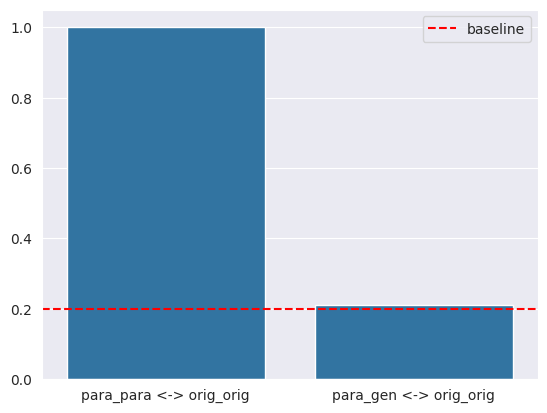

In [28]:
# create bar plot with paraphrased_score, paraphrased_model_generated_score, and horizontal line at 0.2 baseline
sns.barplot(x=["para_para <-> orig_orig", "para_gen <-> orig_orig"], y=[model_score, model_score_model_generated])

plt.axhline(y=0.2, color='r', linestyle='--', label="baseline")
plt.legend()
plt.show()

# 4. Numerical Inaccuracies

In [29]:
a = np.array(list(cosine_similarities_old_structure_combined["lima_0"].values()))
b = np.array(list(cosine_similarities_old_structure_combined["lima_0"].values()))

similarity = cosine_similarity(X=a.reshape(1, -1), Y=b.reshape(1, -1))

print(similarity)
print(similarity[0][0])

[[1.]]
0.9999999999999999


<img src="images/numeric_inaccuracies.png">

In [30]:
pprint(cosine_similarities_old_structure_combined, indent=4, sort_dicts=False)

{   'lima_0': {   'lima_0': 0.527213992021819,
                  'lima_451': 0.003006277331793546,
                  'lima_266': 0.0624190339974516,
                  'lima_947': 0.0069628171269946505,
                  'lima_110': 0.02020262772157636},
    'lima_1': {   'lima_1': 0.38887904242380655,
                  'lima_122': 0.014256711963536915,
                  'lima_22': 0.0009375230408936885,
                  'lima_337': 0.02122887404468714,
                  'lima_290': -0.005593384727465226},
    'lima_2': {   'lima_2': 0.8318462289715409,
                  'lima_162': 0.0013185084269701438,
                  'lima_44': -0.009713040993403192,
                  'lima_1': -0.013953467018113844,
                  'lima_94': 0.015928840508420715},
    'lima_3': {   'lima_3': 0.6009922940368914,
                  'lima_249': 0.04424527181571991,
                  'lima_211': 0.03514289406246416,
                  'lima_110': 0.025866040010554946,
                  'lima_203': 